# Import Libraries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

In [2]:
orders = pd.read_csv('../dataset/orders.csv')
products = pd.read_csv('../dataset/products.csv')
category = pd.read_csv('../dataset/departments.csv')
aisle = pd.read_csv('../dataset/aisles.csv')
ordered_products = pd.read_csv('../dataset/order_products_prior.csv')

# Selecting only prior eval set

# Merging all csv into one dataframe

Understanding the dataset which we have, will proceed to merge the dataframes in accordance to the respective secondary keys then perform cleaning and EDA

In [3]:
def merge_dataframe(df1, df2, on_column):
    df = pd.merge(df1, df2, how = 'left', on = on_column)
    return df

In [4]:
product_with_category = merge_dataframe(products, category, 'department_id')

In [5]:
product_with_category_aisle = merge_dataframe(product_with_category, aisle, 'aisle_id')

In [6]:
ordered_product_full = merge_dataframe(ordered_products, product_with_category_aisle, 'product_id')

In [7]:
full_df = merge_dataframe(orders, ordered_product_full, 'order_id')

# Check and Clean Final DataFrame

In [8]:
full_df.shape

(32640698, 15)

We have over 3 million rows and 15 columns, we will go through the columns one by one, first we will define a function which prints out the basic information for the column and decide if there is a need to explore more on the columns

In [103]:
def check_column(df, column, print_unique = False):
    print('{} has {} values'.format(column, df[column].count()))
    print('{} has {} unique values'.format(column, df[column].nunique()))
    print('{} has {} null values'.format(column, df[column].isnull().sum()))
    print('{} data type is {}'.format(column, df[column].dtypes))
    if print_unique == True:
        print("{}'s unique value are \n {}".format(column, df[column].unique()))

## Order ID

In [99]:
check_column(full_df, 'order_id')

order_id has 32434489 values
order_id has 3214874 unique values
order_id has 0 null values
order_id data type is int64


We have over 3 million unique orders which is a good sample of dataset. There are no null values and the data type is correct

## User ID

In [100]:
check_column(full_df, 'user_id')

user_id has 32434489 values
user_id has 206209 unique values
user_id has 0 null values
user_id data type is int64


We have 206209 unique users, which is a good number of dataset for our analysis, no null values and data type is correct

## Eval Set

Evaluation set is the label detailing if where the data belongs to the test, train or prior set.

In [101]:
check_column(full_df, 'eval_set', print_unique = True)

eval_set has 32434489 values
eval_set has 1 unique values
eval_set has 0 null values
eval_set data type is object
['prior']
eval_set's unique value are 
 ['prior']


We have 3 unique values for evaluations set, we shall explore more and take a look at the sample of each category

In [14]:
full_df[full_df['eval_set'] == 'train'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
28672242,1020935,181083,train,6,0,13,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4329220,1949053,27336,train,17,2,18,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9589053,2144055,60500,train,4,0,10,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
full_df[full_df['eval_set'] == 'test'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
24454762,633772,154254,test,52,0,12,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32539596,1332835,205550,test,5,4,15,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386174,2063129,8868,test,25,6,18,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
full_df[full_df['eval_set'] == 'prior'].sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1752890,2438186,11250,prior,7,1,11,26.0,39475.0,8.0,1.0,Total Greek Strained Yogurt,120.0,16.0,dairy eggs,yogurt
17020240,1563904,107062,prior,2,4,22,26.0,44910.0,10.0,1.0,Organic Spring Mix Salad,123.0,4.0,produce,packaged vegetables fruits
13148477,221474,82670,prior,30,4,14,0.0,49517.0,33.0,1.0,0% Fat Free Organic Milk,84.0,16.0,dairy eggs,milk


Only prior has the full details (because we only merge order_products_prior, we still have order_products_prior) we will only keep rows where eval set is prior

In [17]:
full_df.shape

(32640698, 15)

In [18]:
full_df = full_df[full_df['eval_set'] == 'prior']

In [19]:
full_df.shape

(32434489, 15)

## Order Number

Order number shows the count of repeated orders for the customer

In [104]:
check_column(full_df, 'order_number', print_unique = True)

order_number has 32434489 values
order_number has 99 unique values
order_number has 0 null values
order_number data type is int64
order_number's unique value are 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


There are 99 unique values from 0-99. Seems that instacart only keeps counts of repeated orders up until 99

## Order Day of Week (order_dow)

Order day of week tells us the day of the week the order is made, 0 means it is Sunday, 1 means it is Monday and so on

In [105]:
check_column(full_df, 'order_dow', print_unique = True)

order_dow has 32434489 values
order_dow has 7 unique values
order_dow has 0 null values
order_dow data type is int64
order_dow's unique value are 
 [2 3 4 1 5 0 6]


Order day of the week has 7 unique values which is reasonable as we have 7 days a week. There are no null values and the data type is correct

## Order Hour of Day

Order hour of the day tells us the hour of the day the order is made. It is in 24 hour format. 0 means 12AM, 1 means 1AM

In [106]:
check_column(full_df, 'order_hour_of_day', print_unique = True)

order_hour_of_day has 32434489 values
order_hour_of_day has 24 unique values
order_hour_of_day has 0 null values
order_hour_of_day data type is int64
order_hour_of_day's unique value are 
 [ 8  7 12 15  9 14 16 11 10 19 18 17 13 20  0 21 22  5 23  4  6  1  2  3]


Order hour of the day has 24 unique values which is reasonable as we have 24 hours a day. There are no null values and the data type is correct 

(convert this to date time????)

## Days Since Prior Order

Days since prior order shows the number of days lapsed since the last order by the client

In [107]:
check_column(full_df, 'days_since_prior_order', print_unique = True)

days_since_prior_order has 30356421 values
days_since_prior_order has 31 unique values
days_since_prior_order has 2078068 null values
days_since_prior_order data type is float64
days_since_prior_order's unique value are 
 [nan 15. 21. 29. 28. 19. 20. 14.  0. 30. 10.  3.  8. 13. 27.  6.  9. 12.
  7. 17. 11.  4.  5.  2. 23. 26. 25. 16.  1. 18. 24. 22.]


In [58]:
full_df.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
32640692,2977660,206209,prior,13,1,12,7.0,14197,5.0,1.0,Tomato Paste,9.0,9.0,dry goods pasta,pasta sauce
32640693,2977660,206209,prior,13,1,12,7.0,38730,6.0,0.0,Brownie Crunch High Protein Bar,3.0,19.0,snacks,energy granola bars
32640694,2977660,206209,prior,13,1,12,7.0,31477,7.0,0.0,High Protein Bar Chunky Peanut Butter,3.0,19.0,snacks,energy granola bars
32640695,2977660,206209,prior,13,1,12,7.0,6567,8.0,0.0,Chocolate Peanut Butter Protein Bar,3.0,19.0,snacks,energy granola bars
32640696,2977660,206209,prior,13,1,12,7.0,22920,9.0,0.0,Roasted & Salted Shelled Pistachios,117.0,19.0,snacks,nuts seeds dried fruit


Why only 1 order do not start counting leh??????? now we need to fill... what number to fill leh????

## Product ID and Product Name

Product ID and product number refers to the same thing, the product the store holds. so we will look at them at the same time.

In [43]:
check_column(full_df, 'product_id')

product_id has 32434489 values
product_id has 49677 unique values
product_id has 0 null values
product_id data type is float64


In [44]:
check_column(full_df, 'product_name')

product_name has 32434489 values
product_name has 49677 unique values
product_name has 0 null values
product_name data type is object


Convert product_id to int

In [50]:
full_df['product_id'] = full_df['product_id'].astype('int64')

## Add to Cart Order

add to cart order refers to the order that product is added to the cart for that order

In [108]:
check_column(full_df, 'add_to_cart_order', print_unique = True)

add_to_cart_order has 32434489 values
add_to_cart_order has 145 unique values
add_to_cart_order has 0 null values
add_to_cart_order data type is int64
add_to_cart_order's unique value are 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145]


change this to int

In [72]:
full_df['add_to_cart_order'] = full_df['add_to_cart_order'].astype('int64')

We can see that the highest number of product a client bought in a single purchase is 145

## Reordered

Reordered indicates that the customer has a previous order that contains the said product.

In [110]:
check_column(full_df, 'reordered', print_unique = True)

reordered has 32434489 values
reordered has 2 unique values
reordered has 0 null values
reordered data type is float64
reordered's unique value are 
 [0. 1.]


In [112]:
full_df['reordered'] = full_df['reordered'].astype('int64')

- Only 1 or 0, true or false. 
- 1 means got order that product before, 0 means never order before

## Department ID and Department

Department and department id shows the category the product belongs to, we shall look at them together

In [81]:
check_column(full_df, 'department_id')

department_id has 32434489 values
department_id has 21 unique values
department_id has 0 null values
department_id data type is float64


In [114]:
check_column(full_df, 'department', print_unique = True)

department has 32434489 values
department has 21 unique values
department has 0 null values
department data type is object
department's unique value are 
 ['beverages' 'dairy eggs' 'snacks' 'household' 'produce' 'breakfast'
 'pantry' 'deli' 'frozen' 'personal care' 'meat seafood' 'international'
 'bakery' 'canned goods' 'dry goods pasta' 'alcohol' 'pets' 'babies'
 'other' 'missing' 'bulk']


Most of the values in department are self explanatory, however there are other, missing and bulk, we can take a look into them 

### Missing - Need to clean this.... go in one by one see what is it

In [130]:
full_df[full_df['department'] == 'missing']['product_name'].nunique()

1255

- product name with missing is all missing we can see if we want this or we can discard.
- total products we have is 49677, product with missing  product name is 1255 (approximately 2.5%)

### Other - decide if we want to manually label or drop

In [139]:
full_df[full_df['department'] == 'other']['product_name'].nunique()

548

In [140]:
full_df[full_df['department'] == 'other'].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
941,1611810,11,prior,4,5,13,30.0,19769,6,0,Zero Calorie Tonic Water,6,2.0,other,other
1172,1385564,14,prior,4,6,8,20.0,16776,13,0,Crushed Chili,6,2.0,other,other
1178,1385564,14,prior,4,6,8,20.0,32115,19,0,93/7 Ground Beef,6,2.0,other,other
1202,1691859,14,prior,5,5,8,30.0,32115,16,1,93/7 Ground Beef,6,2.0,other,other
1213,2127409,14,prior,6,1,8,30.0,16776,4,1,Crushed Chili,6,2.0,other,other


- Other products, like matches, ground chilli, tonic water
- total products we have is 49677, product with other is 548 (approximately 1.1%)

### Bulk

In [136]:
full_df[full_df['department'] == 'bulk'].tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
32626819,2721963,206108,prior,11,0,0,11.0,22827,32,0,Organic Black Mission Figs,18,10.0,bulk,bulk dried fruits vegetables
32626893,2387941,206108,prior,12,0,13,14.0,22827,20,1,Organic Black Mission Figs,18,10.0,bulk,bulk dried fruits vegetables
32630656,773874,206135,prior,3,1,17,30.0,5161,6,0,Dried Mango,18,10.0,bulk,bulk dried fruits vegetables
32631607,1799558,206148,prior,10,3,15,9.0,19628,4,0,Organic Blueberries Package,18,10.0,bulk,bulk dried fruits vegetables
32639216,395144,206203,prior,2,0,18,30.0,47489,23,0,Organic Brown Jasmine Rice,68,10.0,bulk,bulk grains rice dried goods


Bulk means dried fruits and vegetables

Department and Department ID has the same number of unique values and has no missing data. There is no need for department ID to be float, we will convert them to integer

In [143]:
full_df['department_id'] = full_df['department_id'].astype('int64')

## Aisle ID and Aisle

Aisle ID and Aisle are referring to the same thing, a more drilled down category of the product. so we will take a look at them together

In [77]:
check_column(full_df, 'aisle_id')

aisle_id has 32434489 values
aisle_id has 134 unique values
aisle_id has 0 null values
aisle_id data type is float64


In [146]:
check_column(full_df, 'aisle', print_unique = True)

aisle has 32434489 values
aisle has 134 unique values
aisle has 0 null values
aisle data type is object
aisle's unique value are 
 ['soft drinks' 'soy lactosefree' 'popcorn jerky' 'paper goods'
 'nuts seeds dried fruit' 'fresh fruits' 'cereal' 'packaged cheese'
 'spreads' 'cream' 'candy chocolate' 'yogurt' 'lunch meat' 'condiments'
 'crackers' 'chips pretzels' 'juice nectars' 'fresh dips tapenades'
 'packaged vegetables fruits' 'prepared soups salads' 'refrigerated'
 'frozen meals' 'energy granola bars' 'breakfast bars pastries' 'granola'
 'oral hygiene' 'packaged poultry' 'frozen vegan vegetarian'
 'pickled goods olives' 'asian foods' 'tofu meat alternatives' 'tea'
 'water seltzer sparkling water' 'breakfast bakery' 'canned meat seafood'
 'baking ingredients' 'bread' 'frozen breads doughs'
 'other creams cheeses' 'fresh vegetables' 'prepared meals'
 'ice cream ice' 'frozen breakfast' 'instant foods' 'dish detergents'
 'red wines' 'plates bowls cups flatware' 'soup broth bouillon'
 'to

In [ ]:
full_df['department'].unique()

Aisle and Aisle ID has the same number of unique values and has no missing data. There is no need for aisle ID to be float, we will convert them to integer

In [80]:
full_df['aisle_id'] = full_df['aisle_id'].astype('int64')

### Duplicates?

In [30]:
full_df['order_id'].duplicated().sum()

29219615

In [31]:
full_df[full_df['user_id'].duplicated()].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,dairy eggs,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,snacks,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,household,paper goods
5,2398795,1,prior,2,3,7,15.0,196.0,1.0,1.0,Soda,77.0,7.0,beverages,soft drinks


In [32]:
columns_left_to_look = [x for x in full_df.columns]
columns_left_to_look

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle_id',
 'department_id',
 'department',
 'aisle']

## Visualisation

In [33]:
def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 40)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax = ax[i], bins = 10, fit = norm, kde = False)
        mean = dataframe[column].mean()
        ax[i].set_title('{} Distribution'.format(str.upper(list_of_columns[i]).replace('_', ' ')), fontsize = 25)
        ax[i].set_xlabel(str.upper(list_of_columns[i]).replace('_', ' '), fontsize = 25)
        ax[i].tick_params(labelsize=25)
        ax[i].set_ylabel(ylabel, fontsize = 25)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

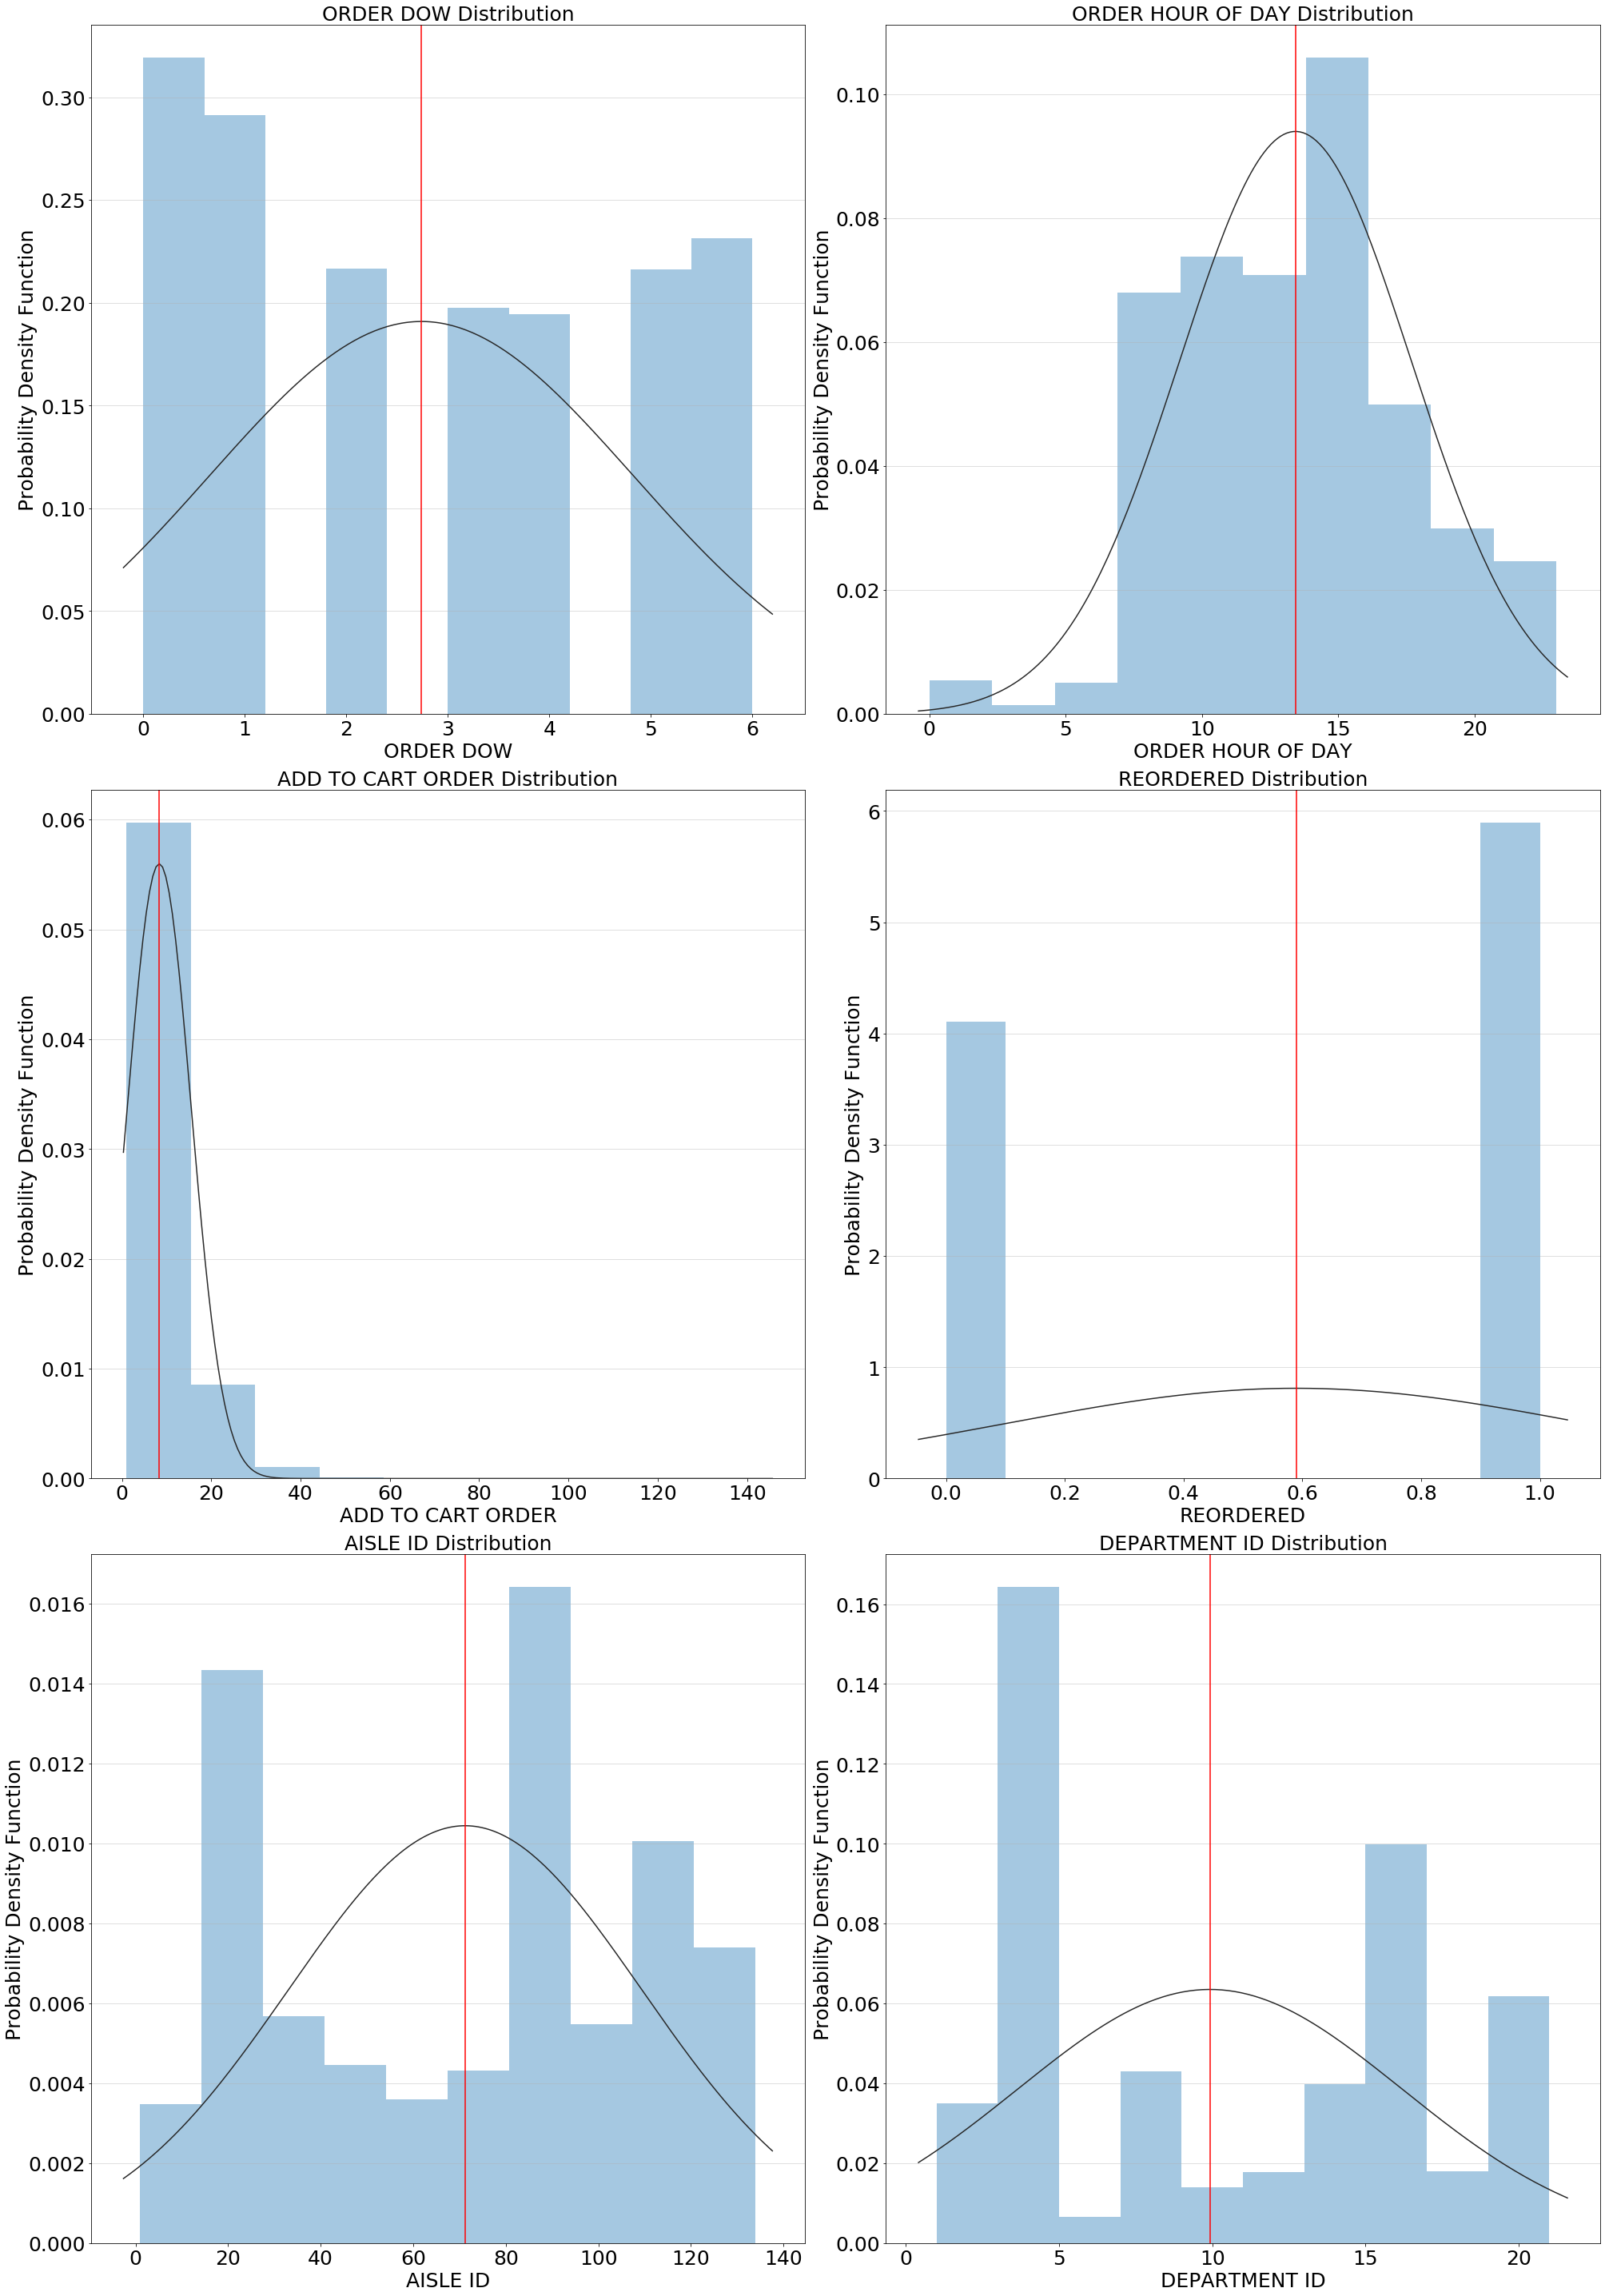

In [34]:
list_of_columns = [x for x in full_df.columns if x not in ['order_id', 'user_id', 'eval_set', 'order_number', 'product_id', 'product_name', 'department', 'aisle', 'days_since_prior_order']]
subplot_histograms(full_df, list_of_columns)

In [35]:
def draw_barplot (df, groupby, target, title, xlabel = None,  ylabel = 'Number', rotation = 0, sort = False):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.grid(False)
    
    if sort == True:
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(color = 'r')
        df.groupby([groupby])[target].nunique().sort_values(ascending = False).head(21).plot(kind = 'bar', color = 'b')
    else:
        df.groupby([groupby])[target].nunique().plot.bar(color = 'b')
        df.groupby([groupby])[target].nunique().plot(color = 'r')
    
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
    xmin,xmax = ax.get_xlim()
    ax.set_xlim([xmin - 0.5, xmax + 0.5])
    ax.set_ylabel(ylabel, fontsize = 20)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

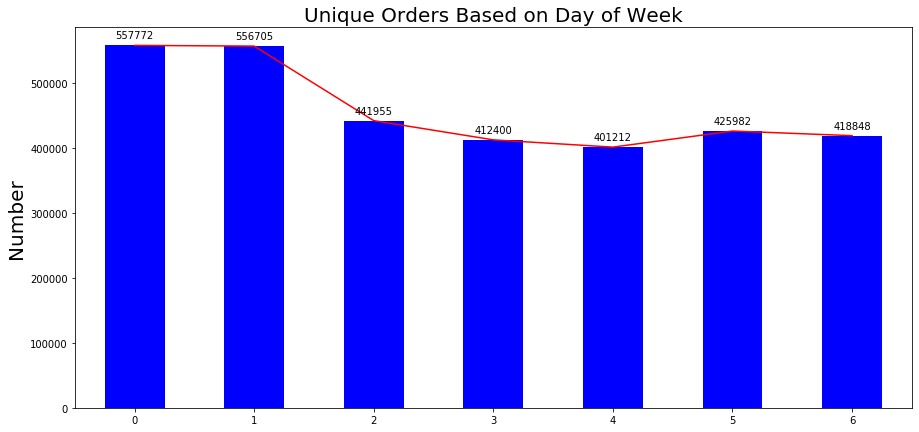

In [36]:
draw_barplot(full_df, 'order_dow', 'order_id', 'Unique Orders Based on Day of Week')

check day 0 is sun or mon

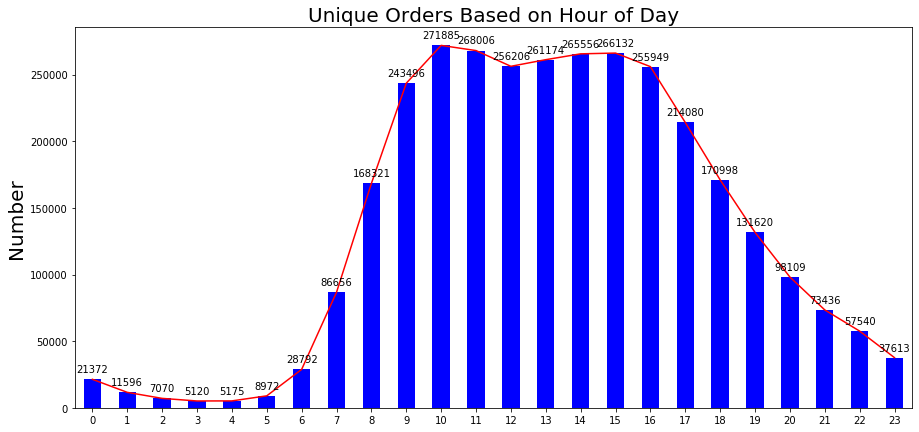

In [37]:
draw_barplot(full_df, 'order_hour_of_day', 'order_id', 'Unique Orders Based on Hour of Day')

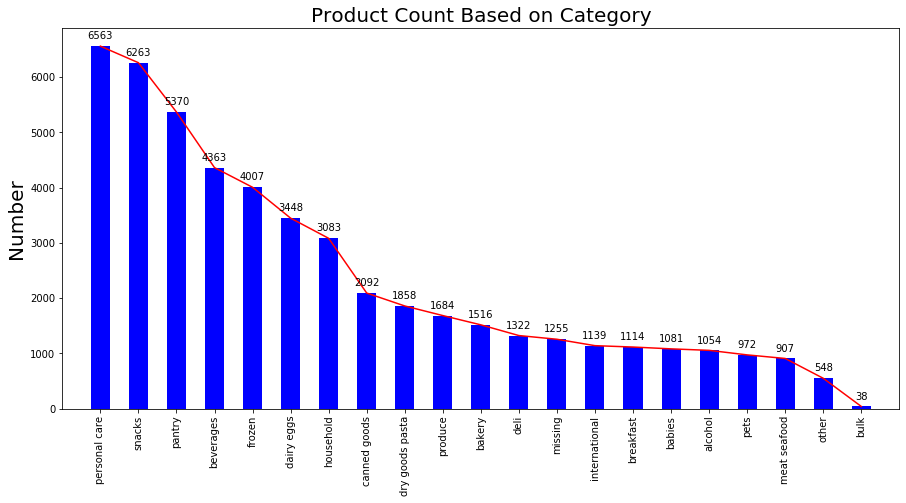

In [38]:
draw_barplot(full_df, 'department', 'product_id', 'Product Count Based on Category', rotation = 90, sort = True)

Alot of products for personal care, but sale not very high. and so on...... see below....

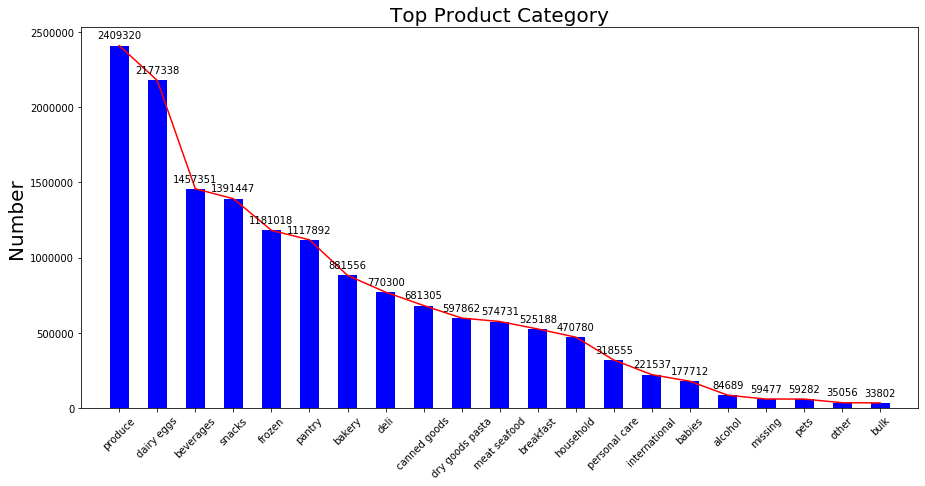

In [39]:
draw_barplot(full_df, 'department', 'order_id', 'Top Product Category', rotation = 45, sort = True)

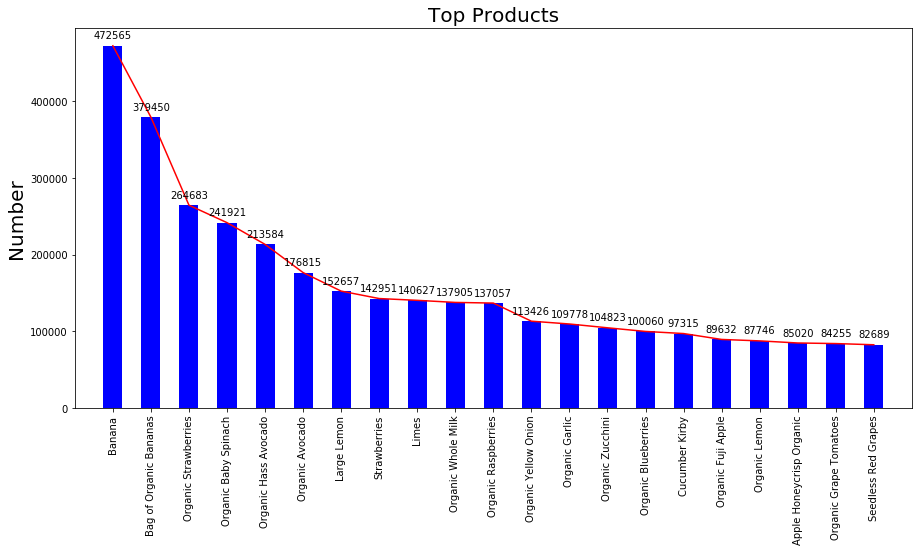

In [40]:
draw_barplot(full_df, 'product_name', 'order_id', 'Top Products', rotation = 90, sort = True)